In [2]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

In [3]:
dic={0:"Fill",64:"Cloud Shadow",128:"Clear",191:"Thin Cloud",255:"Cloud"}


In [4]:
im=[]

train_path="project/subtropical_N/p145_r43_3/"
#test_path="project/mid_latitude_S\p1_r84/"
test_path="project/subtropical_N/p145_r43_3"
for i in list(os.walk(train_path+"bands"))[0][2]:
    print(i)
    try:
        img=Image.open(train_path+"bands/"+i)
        im.append(np.array(img))
    except:
        print("error")
        
im=np.array(im)
im=np.transpose(im,(2,1,0))
        

L71145043_04320010801_B10.TIF
L71145043_04320010801_B40.TIF
L71145043_04320010801_B30.TIF
L72145043_04320010801_B70.TIF
L71145043_04320010801_B20.TIF
L71145043_04320010801_B50.TIF


In [5]:
train_path="project/subtropical_N/p145_r43_3/mask/p145_r43_3_mask_geo.tif"
#test_path="../../datasets/cloud/mid_latitude_S\p1_r84/mask/p1_r84_mask_geo.tif"
img=Image.open(train_path)
mask=np.array(img)
mask=np.transpose(mask,(1,0))

In [6]:
im=im[:8000,:7100,:]
mask=mask[:8000,:7100]
print(im.shape,mask.shape)

(8000, 7100, 6) (8000, 7100)


In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
ms=mask.reshape(-1)
print(ms.shape)
le.fit(ms)
m=le.transform(ms)
msk=m.reshape(8000,7100)
mk=le.inverse_transform(m.reshape(-1)).reshape(8000,7100)


(56800000,)


In [8]:
import numpy as np
(m,n)=np.fromfunction(lambda i,j:(i,j),(100,100),dtype=(int))
p=[]
q=[]
for i in range(0,8000,100):
    for j in range(0,7100,100):
        p.append(i+m)
        q.append(j+n)
        
p=np.array(p)
q=np.array(q)
print(p.shape,q.shape)
feature=im[p,q,:]
label=msk[p,q]
print(feature.shape,label.shape)

(5680, 100, 100) (5680, 100, 100)
(5680, 100, 100, 6) (5680, 100, 100)


In [9]:
n_classes=3
a = np.arange(n_classes)
b = np.zeros((n_classes, n_classes))
b[np.arange(n_classes), a] = 1

In [11]:

x=feature
y=b[label]
print(x.shape,y.shape)

(5680, 100, 100, 6) (5680, 100, 100, 3)


In [12]:
kfold = RepeatedKFold(n_splits=10, n_repeats=1, random_state=36851234)
cvscores = []
X=x.reshape(5680,100*100*6)
label=y.reshape(5680,100*100*3)

for train, test in kfold.split(X, label):
#    print(train.shape,test.shape)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Conv2DTranspose
from tensorflow.keras.models import model_from_json

In [14]:
model=Sequential()
model.add(Conv2D(kernel_size=(3,3),strides=(1,1),padding="same",activation='relu',input_shape=(100,100,6),filters=32))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(kernel_size=(3,3),strides=(1,1),activation='relu',padding="same",filters=64))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same',activation='relu') )
model.add(BatchNormalization())
model.add(Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same',activation='relu') )
model.add(Conv2D(3,(1,1),strides=(1,1),padding='same',activation='sigmoid'))
model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      1760      
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 50, 50, 32)        8224      
__________

In [15]:
for train, test in kfold.split(X, label):
    print(train.shape,test.shape)
    model.fit(x[train,:,:,:],y[train,:,:,:],epochs=10,batch_size=10,validation_data=(x[test,:,:,:],y[test,:,:,:]))

(5112,) (568,)
Train on 5112 samples, validate on 568 samples
Epoch 1/10
5112/5112 [==============================] - 395s 77ms/step - loss: 2.9099 - acc: 0.8584 - val_loss: 2.6430 - val_acc: 0.8733
Epoch 2/10
5112/5112 [==============================] - 355s 70ms/step - loss: 2.4300 - acc: 0.8864 - val_loss: 2.4495 - val_acc: 0.8669
Epoch 3/10
5112/5112 [==============================] - 388s 76ms/step - loss: 2.2619 - acc: 0.8976 - val_loss: 1.8346 - val_acc: 0.9150
Epoch 4/10
1550/5112 [========>.....................] - ETA: 4:13 - loss: 2.1540 - acc: 0.9025

KeyboardInterrupt: 

In [21]:
model_json = model.to_json()
with open("modelcloud.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelcloud.h5")
print("Saved model to disk")
 
# later...
 


Saved model to disk


In [32]:
# load json and create model
json_file = open('modelcloud.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("modelcloud.h5")
print("Loaded model from disk")

Loaded model from disk


In [22]:
predict=model.predict(x)
pred=np.argmax(predict,3)
print(pred.shape)
temp=pred.reshape(-1)
(i,j)=np.fromfunction(lambda i,j:(i,j),(8000,7100),dtype=(int))
m=(i/100).astype(int)
n=(j/100).astype(int)
p=i%100
q=j%100
k=m*71*100*100+n*100*100+p*100+q
grid=temp[k]
print(grid.shape)
print(grid)

(5680, 100, 100)
(8000, 7100)
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


In [23]:
np.where(grid==msk)[0].shape[0]/(8000*7100)

0.8735959154929578

In [24]:
xx=[]
yy=[]
c=[]
d=[]
for i in range(0,8000,10):
    for j in range(0,7100,10):
        xx.append(j)
        yy.append(i)
        c.append(grid[i,j])
        d.append(msk[i,j])


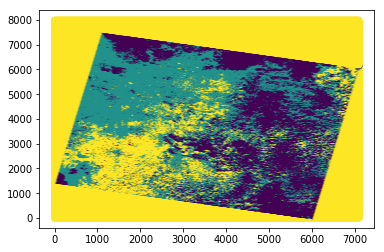

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()  # create figure & 1 axis
ax.scatter(np.array(xx),np.array(yy),c=np.array(c))
fig.savefig('predict.png') 

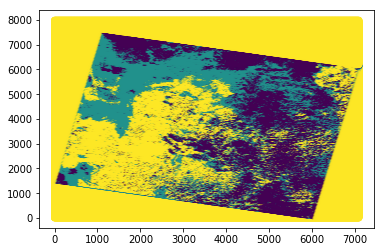

In [26]:
fig, ax = plt.subplots()  # create figure & 1 axis
ax.scatter(np.array(xx),np.array(yy),c=np.array(d))
fig.savefig('mask.png') 

In [35]:
np.where(grid==msk)[0].shape[0]/(8000*7100)

0.8947404401408451

In [21]:
xx=[]
yy=[]
c=[]
d=[]
for i in range(0,8000,10):
    for j in range(0,7100,10):
        xx.append(j)
        yy.append(i)
        c.append(grid[i,j])
        d.append(msk[i,j])


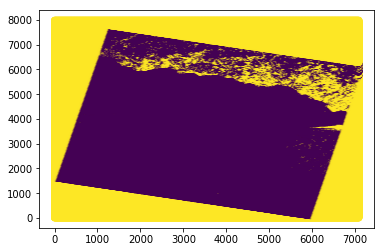

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()  # create figure & 1 axis
ax.scatter(np.array(xx),np.array(yy),c=np.array(c))
fig.savefig('predict.png') 

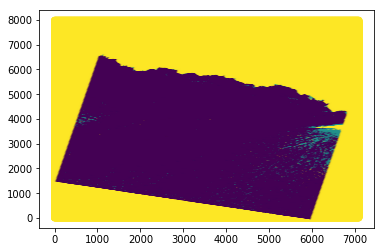

In [23]:
fig, ax = plt.subplots()  # create figure & 1 axis
ax.scatter(np.array(xx),np.array(yy),c=np.array(d))
fig.savefig('mask.png') 